# 模型评估和超参调试的最佳实践

In [29]:
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format='svg'

- 获取模型性能的无偏估计
- 诊断机器学习模型的常见问题
- 微调机器学习模型
- 使用不同的性能指标评估预测模型

## 使用管道简化工作流程


### 加载乳腺癌威斯康星数据集

In [30]:
# 1. 加载数据
import pandas as pd
df = pd.read_csv('wdbc.data', header=None)


In [31]:
# 2. 提取X和y,并且对y的值进行编码
from sklearn.preprocessing import LabelEncoder
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)  # malignant=1,benign=0
le.transform(['M', 'B'])


array([1, 0], dtype=int64)

In [32]:
# 3. 数据集划分
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


### 在管道中结合transformers和estimators

In [33]:
# 在将数据喂给线性分类器前,我们需要1.将特征值进行标准化 2.对特征维度进行降维(通过PCA的方式)
# 我们使用管道的方式来代替分别对训练集和测试集进行上述动作
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(random_state=1))])
pipe_lr.fit(X_train, y_train)
print('Test Accuracy: {:.3}'.format(pipe_lr.score(X_test, y_test)))


Test Accuracy: 0.947


## 使用k折交叉验证法评估模型性能

### Holdout 方法
如之前使用的那般,将数据集按照一定的比例分成训练集和测试集,训练集用于模型训练,测试集用于评估其性能.

然而,我们在一个典型的机器学习应用中,经常会比较不同参数下模型的性能,从而进一步提升模型对未见过数据的预测.这个过程叫模型选择,如果我们重复使用测试集数据进行模型选择,很容易使得模型过拟合.

对于模型选择,使用Holdout方法的一种更好的方式是将其分成三个部分:训练集,验证集和测试集.这种方法的缺点是模型性能对我们分离三种子集的方式很敏感

### K折交叉验证

In [34]:
# 分层K折交叉验证,保证在每一个折中有着与数据集一样比例的类.
import numpy as np
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, random_state=1)
scores = []
for k, (train, test) in enumerate(kfold.split(X_train, y_train)):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: {}, Class dist.: {}, Acc: {:.3}'.format(k+1, np.bincount(y_train[train]), score))


Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956


In [35]:
print('CV accuracy: {:.3} +/- {:.3}'.format(np.mean(scores), np.std(scores)))


CV accuracy: 0.95 +/- 0.0292


In [36]:
# 使用scikit-learn来实现k折交叉验证
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)
print('CV accuracy scores: {}'.format(scores))


CV accuracy scores: [0.89130435 0.97826087 0.97826087 0.91304348 0.93478261 0.97777778
 0.93333333 0.95555556 0.97777778 0.95555556]


In [37]:
print('CV accuracy: {:.3} +/- {:.3}'.format(np.mean(scores), np.std(scores))


CV accuracy: 0.95 +/- 0.0292


## 通过学习曲线和验证曲线调试算法

### 使用学习曲线诊断偏差和方差问题

(0.8, 1.0)

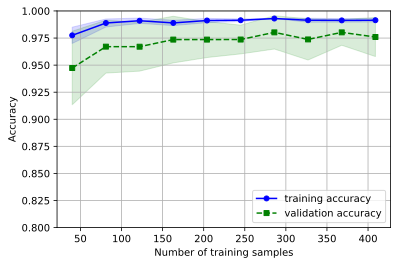

In [44]:
# 使用scikit-learn中learning curve function来评估模型
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
pipe_lr = Pipeline([
    ('scl', StandardScaler()),
    ('clf', LogisticRegression(penalty='l2', random_state=0))])
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipe_lr, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1, 10), cv=10, n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])


### 用验证曲线解决过度拟合和欠拟合问题

(0.8, 1.0)

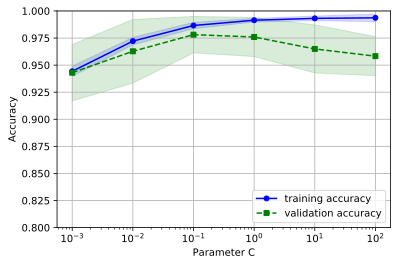

In [47]:
# 通过变化模型参数来观察准确度的变化
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
    estimator=pipe_lr, X=X_train, y=y_train, param_name='clf__C', param_range=param_range, cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])


## 通过网格搜索微调机器学习模型

### 通过网格搜索调试超参
> 暴力穷举搜索范式

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
pipe_svc = Pipeline([('scl', StandardScaler()),
                     ('clf', SVC(random_state=1))])
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [
    {'clf__C': param_range,
     'clf__kernel': ['linear']},
    {'clf__C': param_range,
     'clf__gamma': param_range,
     'clf__kernel': ['rbf']}
]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)


0.978021978021978
{'clf__C': 0.1, 'clf__kernel': 'linear'}


In [51]:
# 将经过上述过程所挑选的最好的estimator用于测试集上
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: {:.3}'.format(clf.score(X_test, y_test)))


Test accuracy: 0.965


### 使用嵌套交叉验证的算法选择

In [54]:
# 在scikit-learn中使用嵌套交叉验证
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=2, n_jobs=-1)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: {:.3} +/- {:.3}'.format(np.mean(scores), np.std(scores)))


CV accuracy: 0.965 +/- 0.0254


In [56]:
# 将SVM和简单决策树分类器进行比较
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), param_grid=[
                  {'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}], scoring='accuracy', cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: {:.3} +/- {:.3}'.format(np.mean(scores), np.std(scores)))


CV accuracy: 0.921 +/- 0.029


很明显,对于这个特定的数据集,SVM比简单决策树分类器更适合.